In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

In [104]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

# Grade Analysis

In [105]:
grade_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
grade_df = grade_df[~grade_df['grade'].isnull()]
grade_df['grade'] = pd.Categorical(grade_df['grade'],
                                         ['A++', 'A+', 'A', 'A-',
                                          'B+', 'B', 'B-',
                                          'C+', 'C', 'C-',
                                          'D+', 'D', 'D-',
                                          'F', 'NAN'])
# Removed as this was accidentally duplicated
grade_df = grade_df[grade_df['assignment_number'] != 105]
grade_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


# Inter-Rater Analysis

In [106]:
def calculate_fleiss_kappa(skill, participant_list, grade_col):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', grade_col]]
    group_df = skill_df[skill_df['participant_id'].isin(participant_list)].sort_values(by='participant_id')
    pivot = group_df.pivot(index='assignment_number', columns='participant_id', values=grade_col)
    if any(pivot.isna().any(axis=1)):
        print('Missing Grade: ', pivot[pivot.isna().any(axis=1)])
        pivot.dropna(inplace=True)
  
    return fleiss_kappa(aggregate_raters(pivot)[0], 'fleiss')

In [107]:
def calculate_all_fleiss_kappa(grade_col):
    results_df = None
    
    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for i in range(1, 28, 4):
            group = list(range(i, i + 4))
            group_str = str(group[0]) + '-' + str(group[-1])
            try:
                results_df = pd.concat([results_df, pd.DataFrame({
                                        'group': group_str,
                                        'skill': skill,
                                        'fliess_kappa': calculate_fleiss_kappa(skill, group, grade_col)}, index=[0])])
            except ValueError:
                print('Error duplicate entries check data for: ', group_str)
    
    return results_df

In [108]:
results_df = calculate_all_fleiss_kappa('grade')
results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
results_df

Missing Grade:  participant_id      13  14  15 16
assignment_number                
306.0              NaN  A+  B+  A
Missing Grade:  participant_id      21   22   23  24
assignment_number                   
10.0               NaN   A+   D+   F
410.0              NaN   C+   A+  A-
654.0              NaN  A++  A++  D-
Missing Grade:  participant_id      9  10  11  12
assignment_number                
117.0              NaN  B  A+  A-
Missing Grade:  participant_id      25   26   27   28
assignment_number                    
394.0              A++  A++  NaN  A++


,group,skill,fliess_kappa
0,1-4,Correctness,0.042673
0,5-8,Correctness,-0.024104
0,9-12,Correctness,0.003440
0,13-16,Correctness,0.041807
0,17-20,Correctness,0.113360
0,21-24,Correctness,0.128276
0,25-28,Correctness,0.046496
0,1-4,Readability,-0.002874
0,5-8,Readability,-0.070433
0,9-12,Readability,-0.069315


In [109]:
pivot = results_df.sort_values(by='group').pivot(index='group', columns='skill', values='fliess_kappa')
pivot

skill,Code Elegance,Correctness,Documentation,Readability
group,,,,
1-4,-0.003257,0.042673,0.001796,-0.002874
5-8,-0.013182,-0.024104,-0.071363,-0.070433
9-12,-0.026386,0.003440,-0.059063,-0.069315
13-16,0.016196,0.041807,-0.001155,-0.057512
17-20,0.035119,0.113360,0.003831,-0.010288
21-24,0.017310,0.128276,-0.036180,0.036232
25-28,0.081149,0.046496,0.063255,0.077050


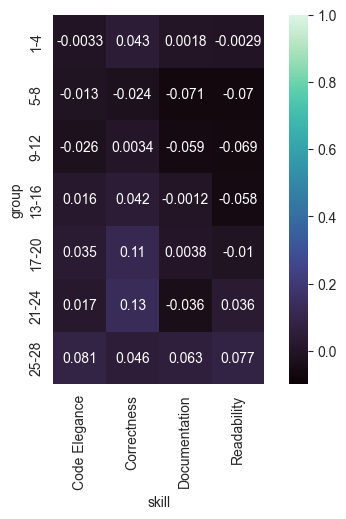

In [110]:
g = sns.heatmap(pivot, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/fleiss_kappa_fine.pdf', bbox_inches='tight')

### Average Fliess Kappa
#### Skill

In [111]:
results_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.015278
1,Correctness,0.050278
2,Documentation,-0.014126
3,Readability,-0.013877


#### Group

In [112]:
results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_39690/3849132905.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()


,group,fliess_kappa
0,1-4,0.009584
1,5-8,-0.044771
2,9-12,-0.037831
3,13-16,-0.000166
4,17-20,0.035506
5,21-24,0.036410
6,25-28,0.066987


## One Away Analysis

In [113]:
def one_away_fleiss_kappa(table):
    table = 1.0 * np.asarray(table)
    submission_count = table.shape[0]
    ratings_count = table.sum()
    grade_count = table.shape[1]
    number_of_graders = 4
    
    p_j = [table[:, i].sum() / ratings_count for i in range(grade_count)]
    p_i = [(sum(table[i, :] * table[i, :]) - number_of_graders) / (number_of_graders * (number_of_graders - 1)) for i in range(submission_count)]
    
    p_bar = sum(p_i) / submission_count
    p_e_bar = sum([j * j for j in p_j])
    
    kappa = (p_bar - p_e_bar) / (1 - p_e_bar)
    
    return kappa

In [114]:
def calculate_one_away_fleiss_kappa(skill, participant_list):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'grade']]
    group_df = skill_df[skill_df['participant_id'].isin(participant_list)].sort_values(by='participant_id')
    group_df['grade_code'] = group_df['grade'].cat.codes
    pivot = group_df.pivot(index='assignment_number', columns='participant_id', values='grade_code')
    if any(pivot.isna().any(axis=1)):
        print('Missing Grade: ', pivot[pivot.isna().any(axis=1)])
        pivot.dropna(inplace=True)

    agg_raters = aggregate_raters(pivot)[0]

    
    one_away_agg_raters = np.empty((agg_raters.shape[0], agg_raters.shape[1] - 1))
    
    # Add each column together (A++ + A+), (A+ + A) etc resulting in 11 one away groups of grades
    for i in range(agg_raters.shape[1] - 1):
        one_away_agg_raters[:, i] = agg_raters[:, i] + agg_raters[:, i + 1]
        
    return one_away_fleiss_kappa(one_away_agg_raters)

In [115]:
results_df = None

for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
    for i in range(1, 28, 4):
        group = list(range(i, i + 4))
        group_str = str(group[0]) + '-' + str(group[-1])
        try:
            results_df = pd.concat([results_df, pd.DataFrame({
                'group': group_str,
                'skill': skill,
                'fliess_kappa': calculate_one_away_fleiss_kappa(skill, group)}, index=[0])])
        except ValueError:
            print('Error duplicate entries check data for: ', group_str)

results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
results_df

Missing Grade:  participant_id     13   14   15   16
assignment_number                   
306.0             NaN  1.0  4.0  2.0
Missing Grade:  participant_id     21   22    23    24
assignment_number                     
10.0              NaN  1.0  10.0  13.0
410.0             NaN  7.0   1.0   3.0
654.0             NaN  0.0   0.0  12.0
Missing Grade:  participant_id     9    10   11   12
assignment_number                   
117.0             NaN  5.0  1.0  3.0
Missing Grade:  participant_id      25   26  27   28
assignment_number                   
394.0              0.0  0.0 NaN  0.0


,group,skill,fliess_kappa
0,1-4,Correctness,0.733631
0,5-8,Correctness,0.749157
0,9-12,Correctness,0.831465
0,13-16,Correctness,0.937131
0,17-20,Correctness,0.908056
0,21-24,Correctness,0.897412
0,25-28,Correctness,0.727039
0,1-4,Readability,0.597684
0,5-8,Readability,0.711181
0,9-12,Readability,0.696207


In [116]:
pivot = results_df.sort_values(by='group').pivot(index='group', columns='skill', values='fliess_kappa')
pivot

skill,Code Elegance,Correctness,Documentation,Readability
group,,,,
1-4,0.598123,0.733631,0.615077,0.597684
5-8,0.743049,0.749157,0.660220,0.711181
9-12,0.716051,0.831465,0.643837,0.696207
13-16,0.815174,0.937131,0.913896,0.925036
17-20,0.779431,0.908056,0.761714,0.865027
21-24,0.847293,0.897412,0.523329,0.938456
25-28,0.825407,0.727039,0.964285,0.851742


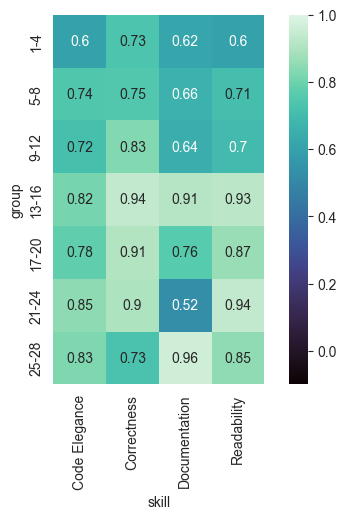

In [117]:
g = sns.heatmap(pivot, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/fleiss_kappa_one_away.pdf', bbox_inches='tight')

### Average Fliess Kappa
#### Skill

In [118]:
results_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.760647
1,Correctness,0.826270
2,Documentation,0.726051
3,Readability,0.797905


#### Group

In [119]:
results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_39690/3849132905.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()


,group,fliess_kappa
0,1-4,0.636129
1,5-8,0.715902
2,9-12,0.721890
3,13-16,0.897809
4,17-20,0.828557
5,21-24,0.801622
6,25-28,0.842118


## Less granular analysis

In [120]:
grade_df['primary_grade'] = grade_df['grade'].apply(lambda x: x[0])
grade_df

,assignment_number,comments,skill,participant_id,batch,grade,primary_grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,B
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,A
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,A
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,A
...,...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++,A
16,353.0,NaN,Documentation,14,1,A++,A
17,422.0,NaN,Documentation,14,1,A++,A
18,480.0,NaN,Documentation,14,1,A++,A


In [121]:
results_df = calculate_all_fleiss_kappa('primary_grade')
results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
results_df

Missing Grade:  participant_id      13 14 15 16
assignment_number              
306.0              NaN  A  B  A
Missing Grade:  participant_id      21 22 23 24
assignment_number              
10.0               NaN  A  D  F
410.0              NaN  C  A  A
654.0              NaN  A  A  D
Missing Grade:  participant_id      9  10 11 12
assignment_number              
117.0              NaN  B  A  A
Missing Grade:  participant_id    25 26   27 28
assignment_number              
394.0              A  A  NaN  A


,group,skill,fliess_kappa
0,1-4,Correctness,0.245128
0,5-8,Correctness,-0.016199
0,9-12,Correctness,0.054746
0,13-16,Correctness,0.276003
0,17-20,Correctness,0.266433
0,21-24,Correctness,0.379183
0,25-28,Correctness,0.284534
0,1-4,Readability,0.141092
0,5-8,Readability,-0.061360
0,9-12,Readability,-0.010668


In [122]:
pivot = results_df.sort_values(by='group').pivot(index='group', columns='skill', values='fliess_kappa')
pivot

skill,Code Elegance,Correctness,Documentation,Readability
group,,,,
1-4,0.110633,0.245128,0.153560,0.141092
5-8,-0.072377,-0.016199,-0.085587,-0.061360
9-12,-0.038231,0.054746,-0.101362,-0.010668
13-16,-0.083827,0.276003,0.025875,-0.002580
17-20,0.104167,0.266433,-0.030889,0.070727
21-24,0.072285,0.379183,-0.004563,0.020133
25-28,0.165580,0.284534,0.341574,0.235238


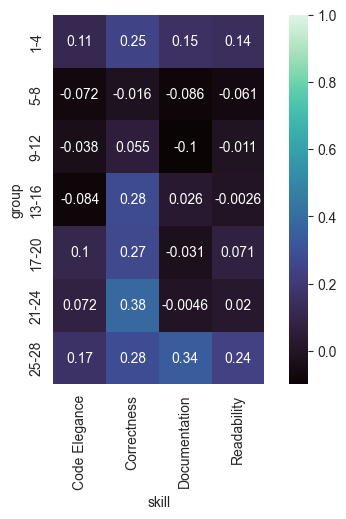

In [123]:
g = sns.heatmap(pivot, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/fleiss_kappa_coarse.pdf', bbox_inches='tight')

### Average Fliess Kappa
#### Skill

In [124]:
results_df[['skill', 'fliess_kappa']].groupby('skill').mean().reset_index()

,skill,fliess_kappa
0,Code Elegance,0.036890
1,Correctness,0.212833
2,Documentation,0.042658
3,Readability,0.056083


#### Group

In [125]:
results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_39690/3849132905.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_df[['group', 'fliess_kappa']].groupby('group').mean().reset_index()


,group,fliess_kappa
0,1-4,0.162603
1,5-8,-0.058881
2,9-12,-0.023879
3,13-16,0.053868
4,17-20,0.102609
5,21-24,0.116759
6,25-28,0.256731


## Distance between grades

In [126]:
def map_participant_group(participant_id):
    if participant_id <= 4:
        return "1-4"
    elif 4 < participant_id <= 8:
        return "5-8"
    elif 8 < participant_id <= 12:
        return "9-12"
    elif 12 < participant_id <= 16:
        return "13-16"
    elif 16 < participant_id <= 20:
        return "17-20"
    elif 20 < participant_id <= 24:
        return "21-24"
    elif 24 < participant_id <= 28:
        return "25-28"

grade_df['group'] = grade_df['participant_id'].apply(map_participant_group)
grade_df['group'] = pd.Categorical(grade_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
grade_df = grade_df.sort_values('group', ascending=True)
grade_df

,assignment_number,comments,skill,participant_id,batch,grade,primary_grade,group
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,A,1-4
13,453.0,The code is somewhat challenging to read.,Readability,2,2,B+,B,1-4
12,143.0,Code readability can be improved by using cons...,Readability,2,2,B,B,1-4
11,223.0,NaN,Readability,2,2,A-,A,1-4
10,575.0,code is understandable and organised,Readability,2,2,A-,A,1-4
...,...,...,...,...,...,...,...,...
2,33.0,NaN,Readability,26,1,A+,A,25-28
3,176.0,NaN,Readability,26,1,A++,A,25-28
4,619.0,NaN,Readability,26,1,A-,A,25-28
4,619.0,The documentation is complete and well-written...,Documentation,28,1,A++,A,25-28


In [127]:
def get_grade(group, skill, assignment_number, participant_id):
    grade = grade_df[(grade_df['group'] == group) &
                         (grade_df['skill'] == skill) &
                         (grade_df['assignment_number'] == assignment_number) &
                         (grade_df['participant_id'] == participant_id)]['grade']

    if grade.empty:
        return None
    return grade

In [128]:
def generate_grade_pairs(group, skill, assignment_number):
    group_bounds = group.split('-')
    pairs = combinations(range(int(group_bounds[0]), int(group_bounds[1]) + 1), r=2)
    
    grade_pairs_df = None
    
    
    for idx, pair in enumerate(pairs):
        grade_1 = get_grade(group, skill, assignment_number, pair[0])
        grade_2 = get_grade(group, skill,assignment_number, pair[1])
    
        if grade_pairs_df is None:
            grade_pairs_df = pd.DataFrame({'group': group,
                                              'skill': skill,
                                              'assignment_number': assignment_number,
                                              'participant_id_1': pair[0],
                                              'participant_id_2': pair[1],
                                              'grade_1': grade_1,
                                              'grade_2': grade_2
                                              }, index=[idx])
        else:
            grade_pairs_df = pd.concat([
                grade_pairs_df,
                pd.DataFrame({'group': group, 'assignment_number': assignment_number, 'skill': skill,
                              'participant_id_1': pair[0],
                              'participant_id_2': pair[1],
                              'grade_1': grade_1,
                              'grade_2': grade_2
                              }, index=[idx])]
            )
    return grade_pairs_df
        

In [129]:
 dist_df = None
 
for group in tqdm(grade_df['group'].unique()):
    for skill in grade_df['skill'].unique():
        for n in grade_df[(grade_df['group'] == group) &
                           (grade_df['skill'] == skill)]['assignment_number'].unique():
            if  dist_df is None:
                dist_df = generate_grade_pairs(group, skill, n)
            else:
                dist_df = pd.concat([dist_df, generate_grade_pairs(group, skill, n)])

dist_df =dist_df.dropna()
dist_df['grade_1_code'] = dist_df['grade_1'].cat.codes
dist_df['grade_2_code'] = dist_df['grade_2'].cat.codes
dist_df['distance'] = dist_df['grade_1_code'] - dist_df['grade_2_code']
                
dist_df

 29%|██▊       | 2/7 [00:02<00:06,  1.22s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_39690/3620516811.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(group, skill, n)])
 43%|████▎     | 3/7 [00:03<00:04,  1.19s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_39690/3620516811.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(group, skill, n)])
 71%|███████

,group,skill,assignment_number,participant_id_1,participant_id_2,grade_1,grade_2,grade_1_code,grade_2_code,distance
0,1-4,Readability,302.0,1,2,A,A,2,2,0
5,1-4,Readability,261.0,3,4,A++,A,0,2,-2
3,1-4,Readability,542.0,2,3,A-,A++,3,0,3
2,1-4,Readability,277.0,1,4,A,A-,2,3,-1
1,1-4,Readability,303.0,1,3,B,A+,5,1,4
...,...,...,...,...,...,...,...,...,...,...
1,25-28,Documentation,555.0,25,27,A++,A-,0,3,-3
2,25-28,Documentation,33.0,25,28,A++,A++,0,0,0
3,25-28,Documentation,176.0,26,27,A++,B+,0,4,-4
4,25-28,Documentation,619.0,26,28,A++,A++,0,0,0


In [130]:
def generate_heatmap_data(skill, group):
    temp_df = dist_df[(dist_df['skill'] == skill) & (dist_df['group'] == group)].sort_values(['participant_id_1', 'participant_id_2'])

    temp_df = temp_df.pivot_table(index='participant_id_1', columns='participant_id_2', values='distance')
    return temp_df

In [131]:
test_df = generate_heatmap_data('Correctness', '1-4')

1-4 Readability
1-4 Correctness
1-4 Code Elegance
1-4 Documentation
5-8 Readability
5-8 Correctness
5-8 Code Elegance
5-8 Documentation
9-12 Readability
9-12 Correctness
9-12 Code Elegance
9-12 Documentation
13-16 Readability
13-16 Correctness
13-16 Code Elegance
13-16 Documentation
17-20 Readability
17-20 Correctness
17-20 Code Elegance
17-20 Documentation
21-24 Readability
21-24 Correctness
21-24 Code Elegance
21-24 Documentation
25-28 Readability
25-28 Correctness
25-28 Code Elegance
25-28 Documentation


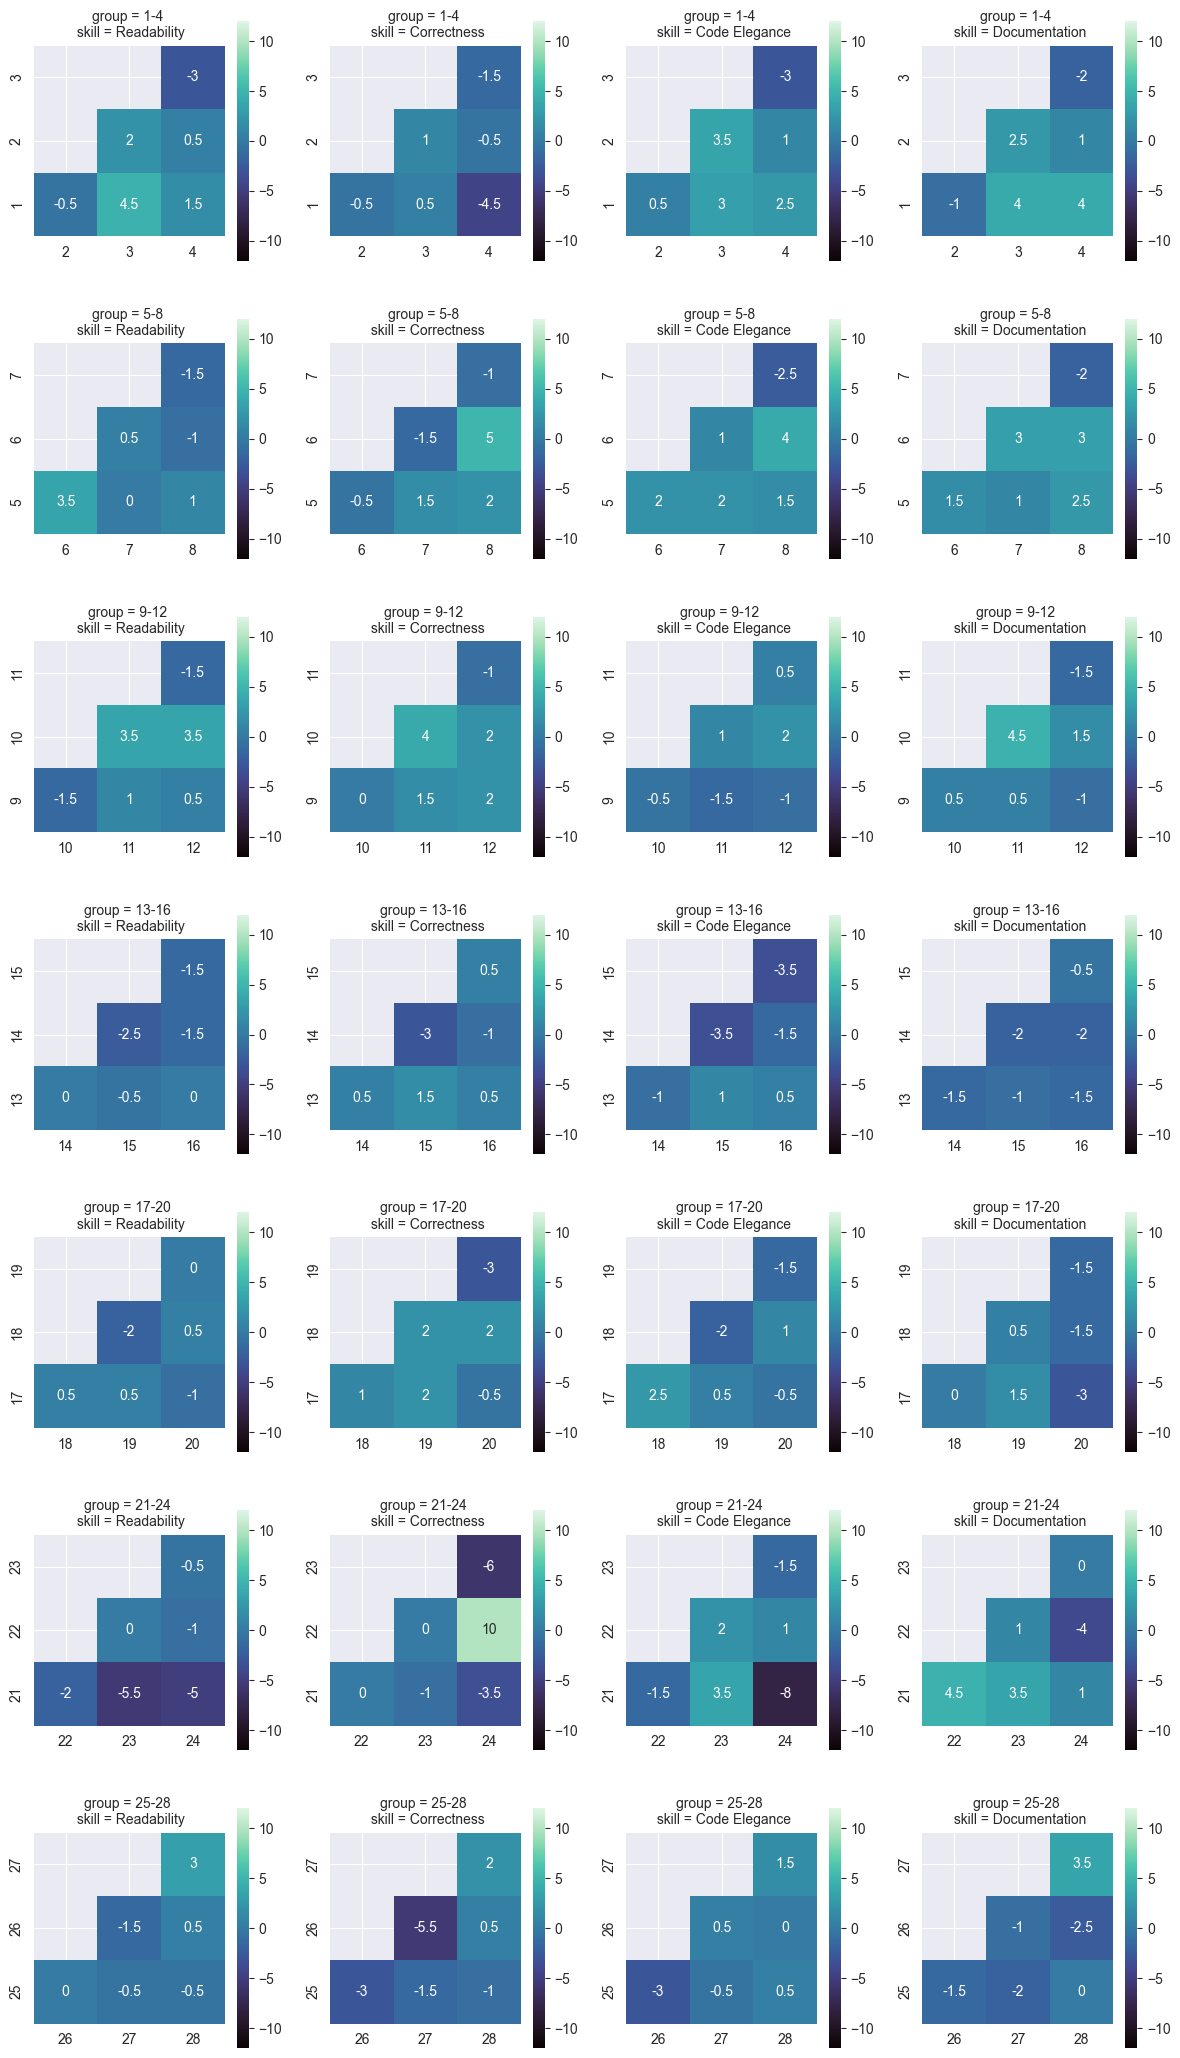

In [132]:
skills = dist_df['skill'].unique()
groups = dist_df['group'].unique()
g = sns.FacetGrid(dist_df, row='group', col='skill',
                  col_order=skills, row_order=groups, sharey=False, sharex=False)
g.set_titles('{row_var} = {row_name} \n {col_var} = {col_name}')

for col_idx, group in enumerate(groups):
    for row_idx, skill in enumerate(skills):
        print(group, skill)
        a = sns.heatmap(ax=g.axes[col_idx, row_idx], data=generate_heatmap_data(skill=skill, group=group), square=True, cmap=sns.color_palette("mako", as_cmap=True), annot=True, vmin=dist_df['distance'].min(), vmax=dist_df['distance'].max())
        a.set(xlabel='', ylabel='')
        a.invert_yaxis()


g.savefig('plots/inter_rater_grade_dist.pdf', bbox_inches='tight')

# Intra-Rater Relability

In [133]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [134]:
intra_rater_df = grade_df[grade_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'grade']]
intra_rater_df = intra_rater_df.sort_values('grade')
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
3,176.0,Readability,26,1,A++
3,389.0,Readability,18,1,A++
9,686.0,Code Elegance,25,2,A++
16,684.0,Code Elegance,18,2,A++
19,144.0,Readability,3,1,A++
...,...,...,...,...,...
7,97.0,Readability,10,1,F
14,682.0,Code Elegance,10,2,F
14,682.0,Readability,10,2,F
7,97.0,Documentation,10,1,F


### Map replacement IDs to original IDs

In [135]:
intra_rater_df['assignment_number'] = intra_rater_df['assignment_number'].apply(lambda x: x if x not in DUPLICATE_MAP.keys() else DUPLICATE_MAP[x])
intra_rater_df['grade_code'] = intra_rater_df['grade'].cat.codes
intra_rater_df

,assignment_number,skill,participant_id,batch,grade,grade_code
3,176.0,Readability,26,1,A++,0
3,389.0,Readability,18,1,A++,0
9,176.0,Code Elegance,25,2,A++,0
16,389.0,Code Elegance,18,2,A++,0
19,144.0,Readability,3,1,A++,0
...,...,...,...,...,...,...
7,97.0,Readability,10,1,F,13
14,97.0,Code Elegance,10,2,F,13
14,97.0,Readability,10,2,F,13
7,97.0,Documentation,10,1,F,13


In [136]:
pivot = intra_rater_df.pivot(index=['assignment_number', 'skill', 'participant_id'], columns='batch', values='grade').reset_index()
pivot.columns = ['assignment_number', 'skill', 'participant_id', 'grade_1', 'grade_2']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2
0,97.0,Code Elegance,9,A-,B+
1,97.0,Code Elegance,10,F,F
2,97.0,Code Elegance,11,A-,A+
3,97.0,Code Elegance,12,A-,B
4,97.0,Correctness,9,B+,A
...,...,...,...,...,...
107,559.0,Documentation,8,A,A
108,559.0,Readability,5,A-,B+
109,559.0,Readability,6,A-,A++
110,559.0,Readability,7,A+,A+


## Distance between grade notches

In [137]:
pivot['grade_1_code'] = pivot['grade_1'].cat.codes
pivot['grade_2_code'] = pivot['grade_2'].cat.codes
pivot['distance'] = pivot['grade_1_code'] - pivot['grade_2_code']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2,grade_1_code,grade_2_code,distance
0,97.0,Code Elegance,9,A-,B+,3,4,-1
1,97.0,Code Elegance,10,F,F,13,13,0
2,97.0,Code Elegance,11,A-,A+,3,1,2
3,97.0,Code Elegance,12,A-,B,3,5,-2
4,97.0,Correctness,9,B+,A,4,2,2
...,...,...,...,...,...,...,...,...
107,559.0,Documentation,8,A,A,2,2,0
108,559.0,Readability,5,A-,B+,3,4,-1
109,559.0,Readability,6,A-,A++,3,0,3
110,559.0,Readability,7,A+,A+,1,1,0


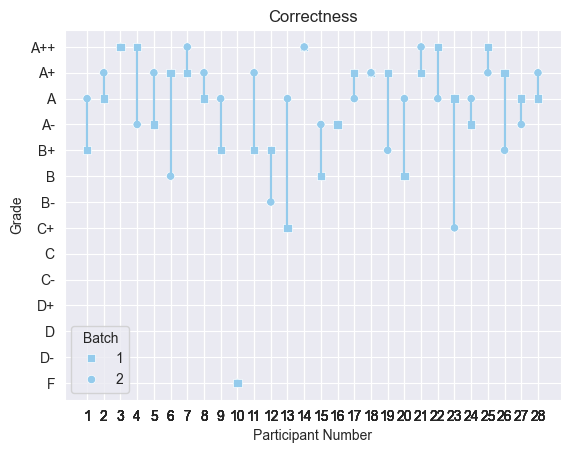

In [138]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Correctness'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Correctness'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)
    
dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Correctness', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/correctness_distance.pdf', bbox_inches='tight')

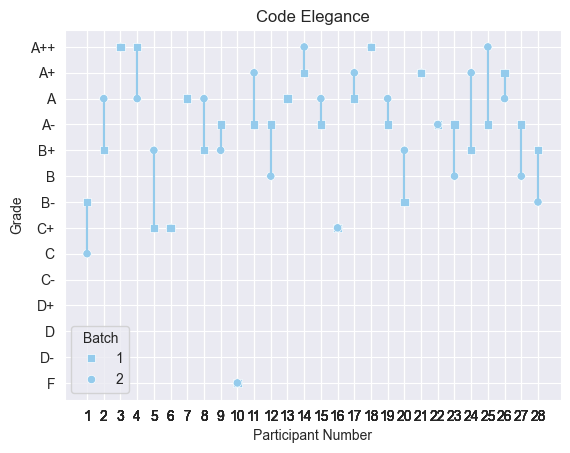

In [139]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Code Elegance', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/code_elegance_distance.pdf', bbox_inches='tight')

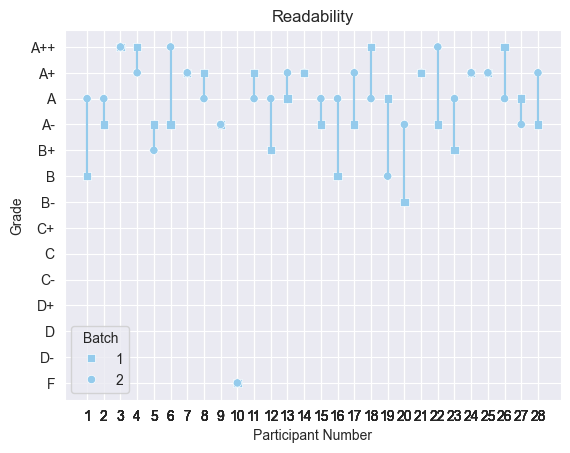

In [140]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Readability'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Readability'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Readability', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/readability_distance.pdf', bbox_inches='tight')

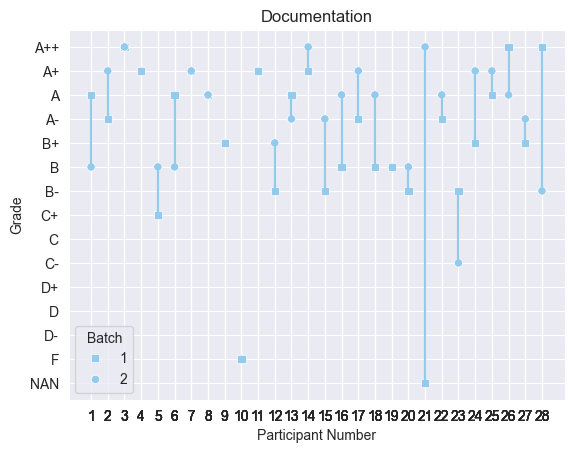

In [141]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Documentation'], x='participant_id', y='grade', style='batch', color=blue, markers=['s', 'o'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Documentation'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Documentation', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/documentation_distance.pdf', bbox_inches='tight')

# Summary of Grades per skill

In [142]:
grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})
grade_count_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_39690/1988006025.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})


,skill,grade,count
0,Code Elegance,A++,148
1,Code Elegance,A+,197
2,Code Elegance,A,189
3,Code Elegance,A-,132
4,Code Elegance,B+,116
5,Code Elegance,B,127
6,Code Elegance,B-,73
7,Code Elegance,C+,53
8,Code Elegance,C,21
9,Code Elegance,C-,13


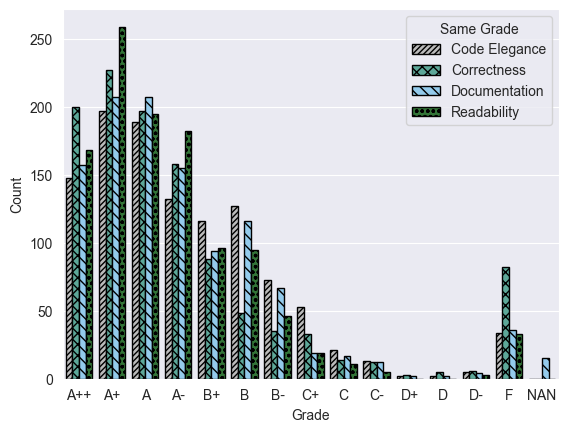

In [143]:
grade_plt = sns.barplot(x='grade', y='count', data=grade_count_df, hue='skill')

hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, grade_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

grade_plt.set(xlabel='Grade', ylabel='Count')
handles = grade_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


grade_plt.legend(title='Same Grade')
grade_plt.get_figure().savefig('plots/grade_count.pdf', bbox_inches='tight')

In [144]:
lower_b = grade_count_df[~grade_count_df['grade'].isin(['A++', 'A+', 'A', 'A-', 'B+', 'B', 'B-'])]['count'].sum()

(lower_b / grade_count_df['count'].sum()) * 100

10.423232778027916